In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add local package root
sys.path.append(".")

from bayes_ordinal.models.cumulative import cumulative_model
from bayes_ordinal.workflow.iterative import run_workflow


In [2]:
np.random.seed(42)
n = 100
X = np.random.normal(size=(n, 2))

true_beta = np.array([1.0, -0.5])
eta = X @ true_beta

# Define cutpoints and calculate probabilities
cutpoints = [-0.5, 0.5]
probs = np.stack([
    1 / (1 + np.exp(-(cutpoints[0] - eta))),
    1 / (1 + np.exp(-(cutpoints[1] - eta))),
], axis=1)

# Convert latent variable to ordinal class (0, 1, 2)
y = np.digitize(eta, cutpoints)

# Display outcome class distribution
np.unique(y, return_counts=True)


(array([0, 1, 2]), array([38, 32, 30]))

Sampling: [alpha, beta, y_obs]


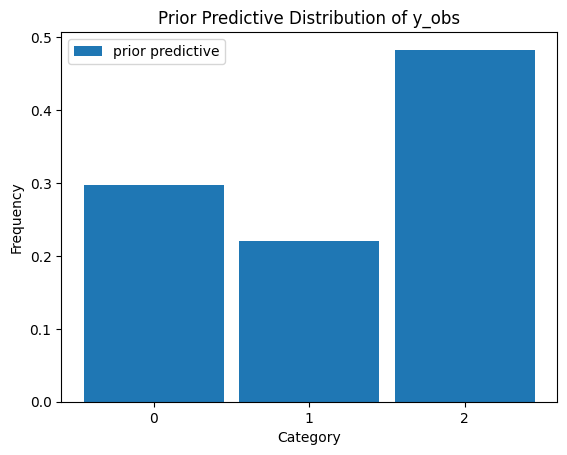

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_obs]


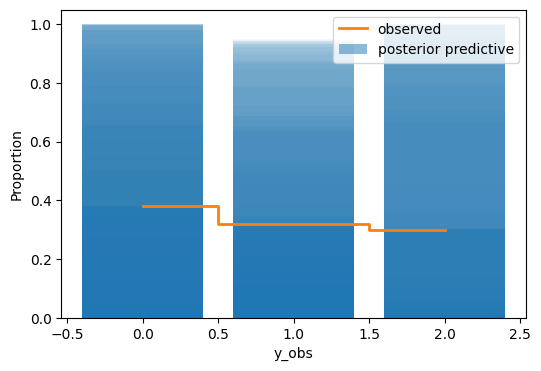

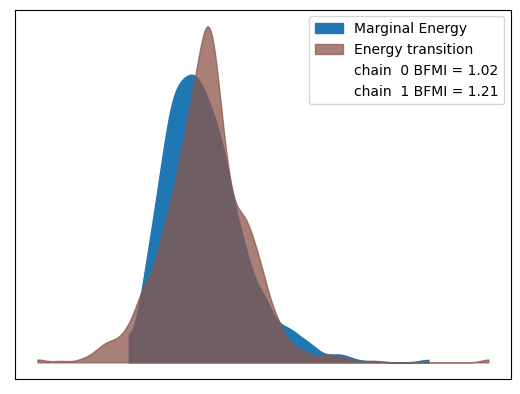

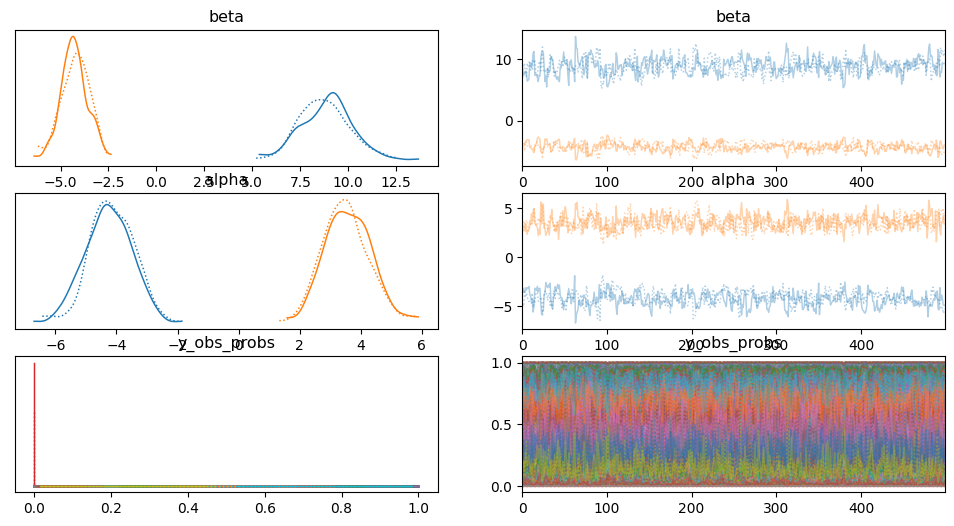

/Users/adithyan/Documents/MScProject/bayes_ordinal/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


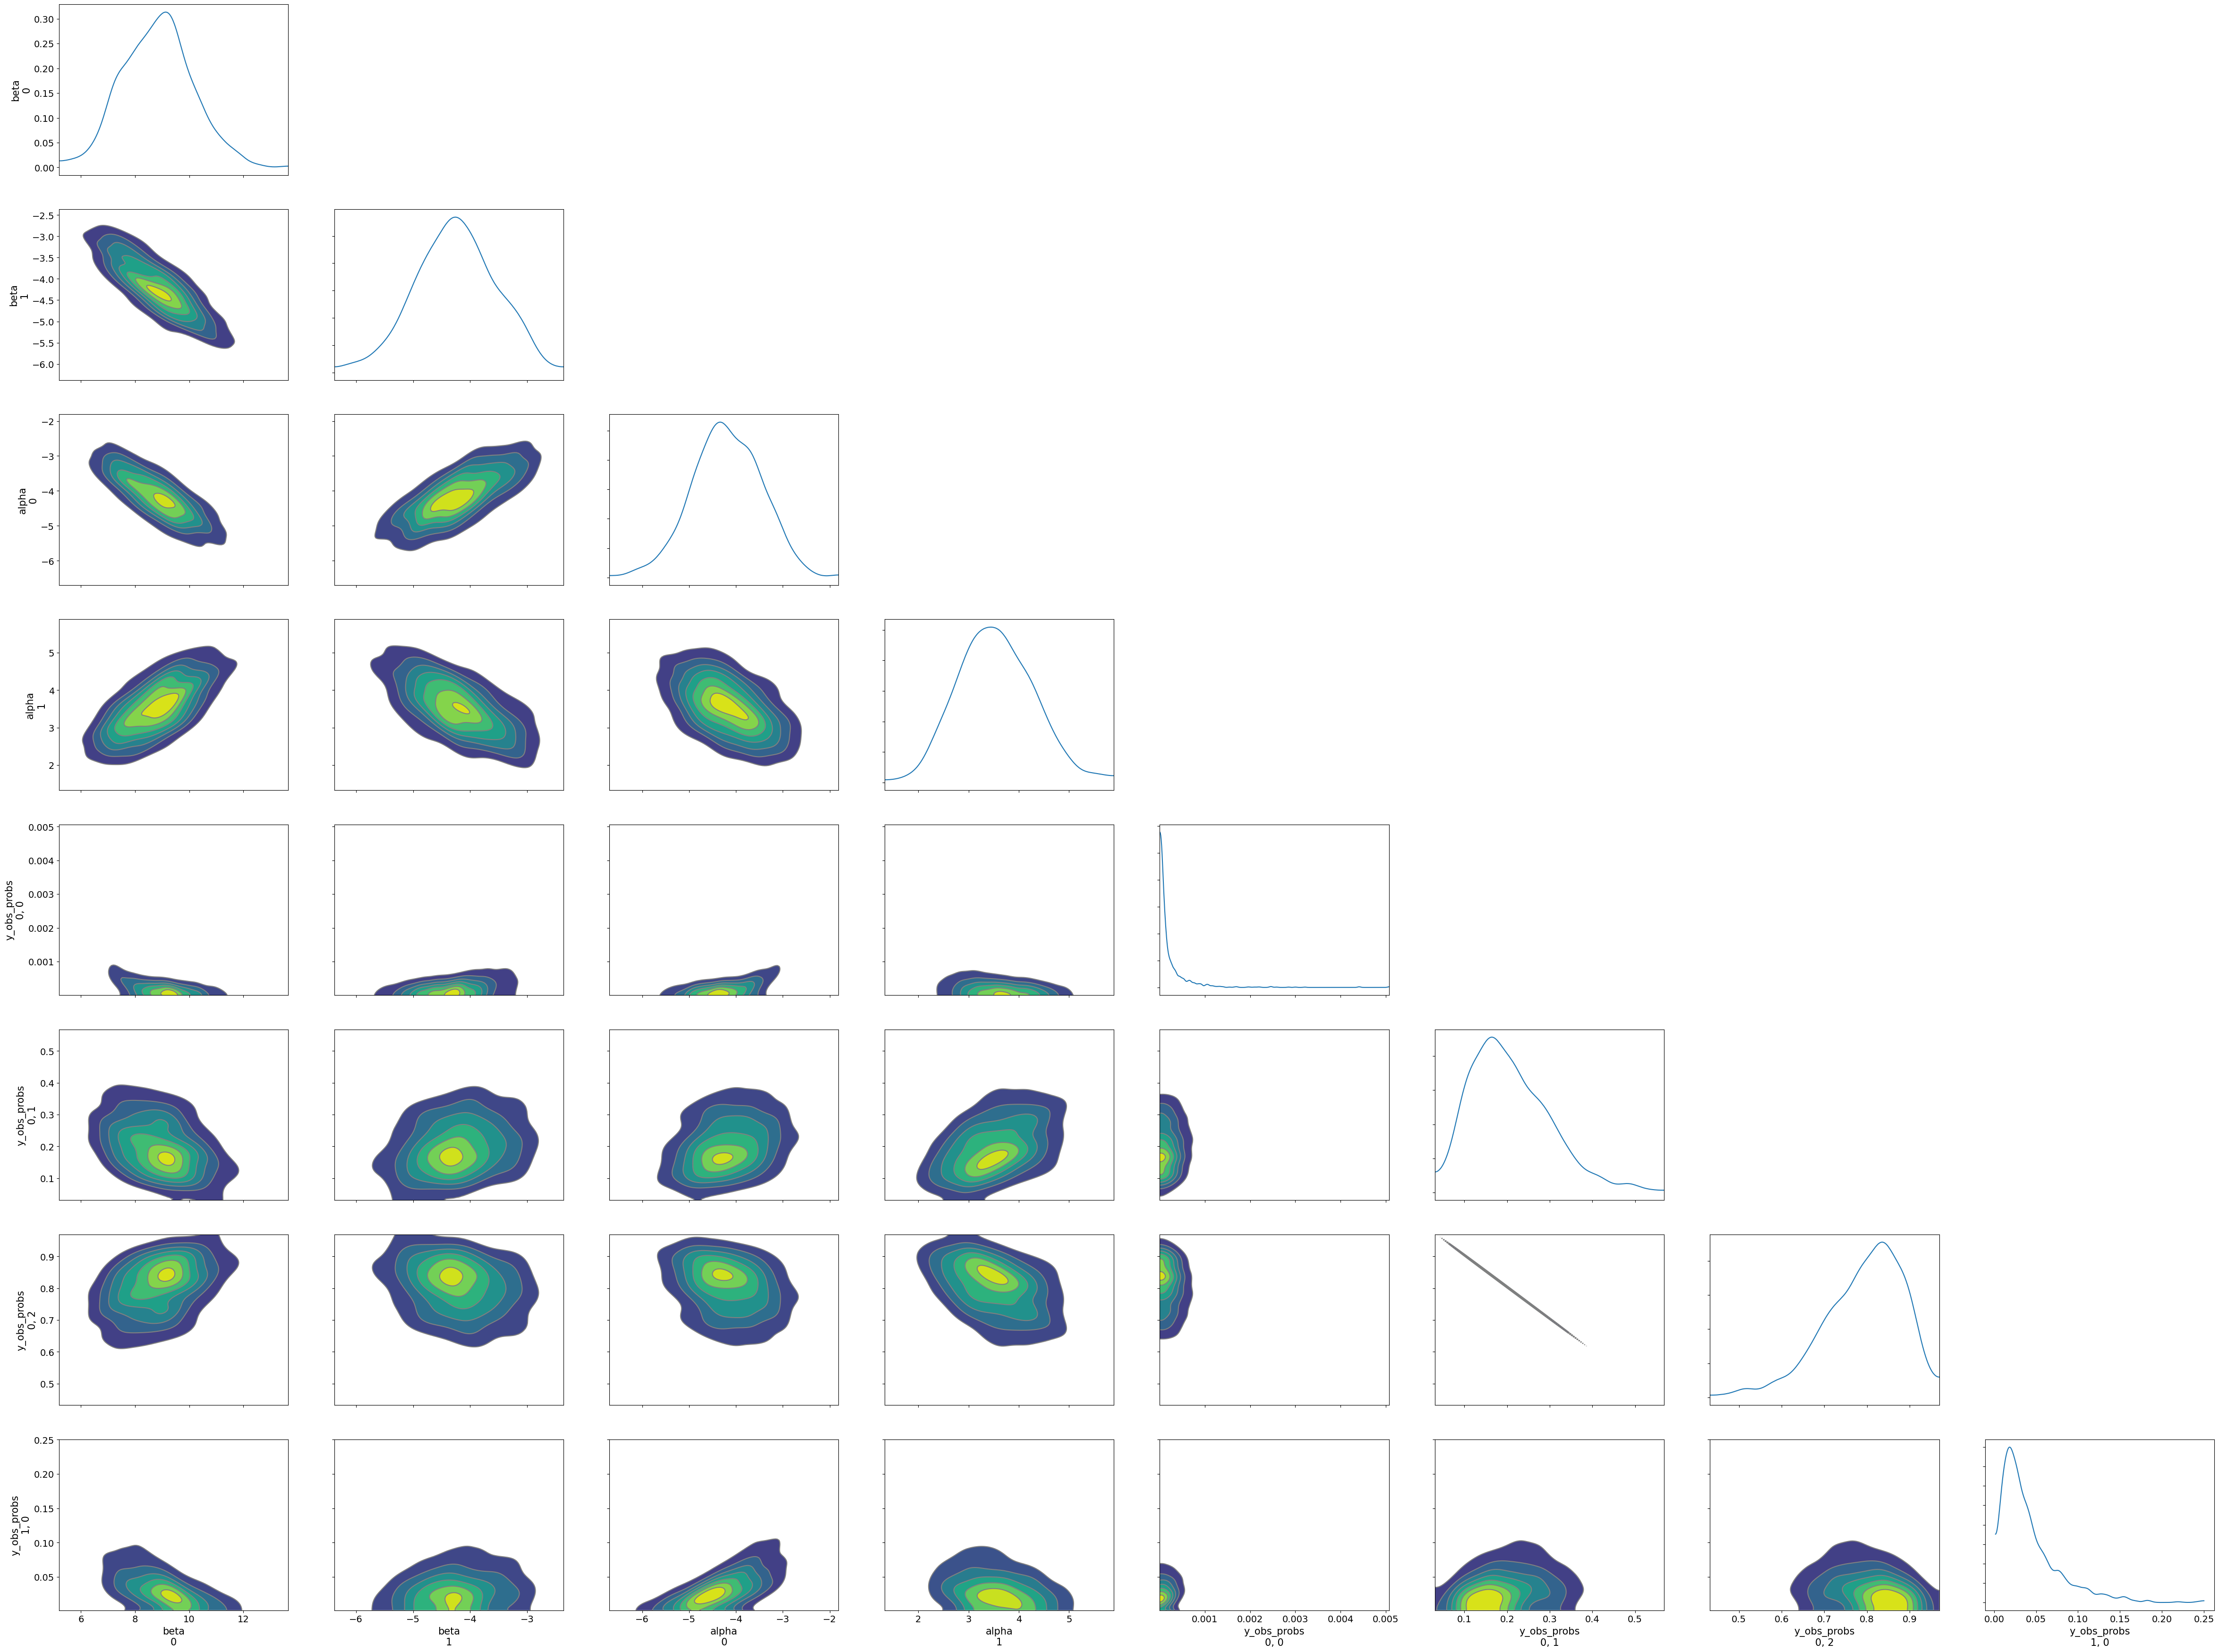

/Users/adithyan/Documents/MScProject/bayes_ordinal/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [3]:
results = run_workflow(
    model_fn=cumulative_model,
    y=y,
    X=X,
    K=3,
    config={
        "draws": 500,
        "tune": 500,
        "chains": 2,
        "smoke_test": False,
        "run_prior": True,
        "run_ppc": True,
        "run_diagnostics": True,
        "run_cv": True,
        "ppc_kind": "proportions",
        "progressbar": True,
    }
)


In [4]:
results["diagnostics"]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,n_divergences,max_energy_diff
beta[0],8.82,1.28,6.41,11.22,0.07,0.05,318.61,493.47,1.01,0,13.887463
beta[1],-4.25,0.70,-5.53,-2.96,0.04,0.03,321.91,371.46,1.01,0,13.887463
alpha[0],-4.20,0.73,-5.50,-2.78,0.04,0.03,308.70,444.83,1.01,0,13.887463
alpha[1],3.55,0.74,2.26,4.97,0.04,0.03,422.11,693.50,1.00,0,13.887463
"y_obs_probs[0, 0]",0.00,0.00,0.00,0.00,0.00,0.00,288.04,441.73,1.01,0,13.887463
...,...,...,...,...,...,...,...,...,...,...,...
"y_obs_probs[98, 1]",0.02,0.02,0.00,0.04,0.00,0.00,523.59,662.85,1.00,0,13.887463
"y_obs_probs[98, 2]",0.00,0.00,0.00,0.00,0.00,0.00,304.67,441.66,1.01,0,13.887463
"y_obs_probs[99, 0]",0.00,0.00,0.00,0.00,0.00,0.00,287.45,391.18,1.01,0,13.887463
"y_obs_probs[99, 1]",0.16,0.09,0.03,0.32,0.00,0.00,909.75,700.48,1.00,0,13.887463


In [5]:
results["cv"]

Computed from 1000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -16.43     2.07
p_loo        1.47        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       92   92.0%
 (0.5, 0.7]   (ok)          6    6.0%
   (0.7, 1]   (bad)         1    1.0%
   (1, Inf)   (very bad)    1    1.0%

In [6]:
ppc = results["ppc"]
ppc.posterior_predictive["y_obs"].shape

(2, 500, 100)

In [7]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# ── 1. PSIS-LOO with exact refit for bad k’s ──────────────────────────
# Assume your idata has a log_likelihood group called "log_lik"
loo_refit = az.loo(
    idata,
    pointwise=True,
    method="pareto_refit"     # will re-fit each problematic case
)
print(loo_refit)

# ── 2. 5-fold cross-validation ────────────────────────────────────────
# Extract posterior samples and a ll function
posterior = idata.posterior
log_lik = idata.log_likelihood["y_obs"]  # shape (chain, draw, obs)

# Make a simple function to recompute log-lik for held-out folds:
def log_lik_for_holdout(fit, x_holdout, y_holdout):
    """Refit model on training data and return ll on holdout."""
    # *** you’ll need to wrap your model-fitting call here exactly
    #    as you did the first time, but replacing observed data with
    #    the training splits.  Then return fit.log_likelihood["y_obs"].values.
    pass

kf = KFold(n_splits=5, shuffle=True, random_state=2)
fold_elpd = []
for train_idx, test_idx in kf.split(y_obs):
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y_obs[train_idx], y_obs[test_idx]
    hold_ll = log_lik_for_holdout(model, x_test, y_test)
    # approximate elpd for this fold
    fold_elpd.append(hold_ll.sum(axis=-1).mean())
print("5-fold ELPD:", np.sum(fold_elpd))

# ── 3. Posterior predictive checks ────────────────────────────────────
# Assume your idata has a group "posterior_predictive" with "y_obs"
az.plot_ppc(
    idata,
    kind="hist",
    data_pairs={"y_obs": "y_obs"},
    textsize=12
)
plt.title("PPC: Observed vs simulated histograms")
plt.show()

# You can also check means & variance
az.plot_ppc(
    idata,
    kind="scatter",
    var_names=["y_obs"],
    coords={"y_obs_dim_0": [0, 1, 2]},  # for categorical, sample a few
)
plt.show()

# ── 4. Marginal effects with uncertainty ──────────────────────────────
# e.g. if your model has a single predictor x and a softmax output for cat=0,1,2:
x_grid = np.linspace(x_obs.min(), x_obs.max(), 200)
pp = model.predict(idata, {"x": x_grid})  # shape (chain, draw, x_grid, cat)
mean_pp = pp.mean(axis=(0, 1))
hdi_pp = az.hdi(pp, hdi_prob=0.89)

for cat in range(pp.shape[-1]):
    plt.plot(x_grid, mean_pp[:, cat], label=f"class {cat}")
    low, high = hdi_pp.sel(hdi=["lower", "higher"]).values[:,:,cat]
    plt.fill_between(x_grid, low, high, alpha=0.3)
plt.legend()
plt.xlabel("x")
plt.ylabel("P(y = k)")
plt.title("Marginal model-based probabilities ±89% HDI")
plt.show()

# ── 5. Compare an alt model ──────────────────────────────────────────
# Say alt_model is the same but with a quadratic term or different prior
idata_alt = alt_model.fit(...)
loo_main = az.loo(idata, pointwise=False)
loo_alt  = az.loo(idata_alt, pointwise=False)
comp = az.compare({"main": idata, "alt": idata_alt}, method="loo")
print(comp)


NameError: name 'idata' is not defined

In [11]:
import arviz as az
import pymc as pm
# 1. Load your old trace:
trace = pm.load_trace("/mnt/data/azones_los.pkl", model=azones)

# 2. Convert to InferenceData (give it the model so it can grab coords & dims):
idata = az.from_pymc3(
    trace=trace,
    model=azones,
    coords={"zone": zone_names},     # if you need to supply coords
    dims={"a_zone": ["zone"]},        # likewise, if you have named dims
)

# 3. Compute LOO:
loo = az.loo(idata)
print(loo)


AttributeError: module 'pymc' has no attribute 'load_trace'

In [17]:
# Cell 1: Imports & Seed
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from bayes_ordinal.models.cumulative import cumulative_model
from bayes_ordinal.workflow.iterative import run_workflow

plt.rcParams["figure.figsize"] = (8, 4)

np.random.seed(42)


In [19]:
# Cell 2: Simulate synthetic ordinal data
n = 100
X = np.random.normal(size=(n, 2))
true_beta = np.array([1.0, -0.5])
eta = X @ true_beta

# define cutpoints for 3 categories
cutpoints = [-0.5, 0.5]
# convert latent η into ordinal outcomes 0,1,2
y = np.digitize(eta, bins=cutpoints)
K = 3


Sampling: [alpha, beta, y_obs]


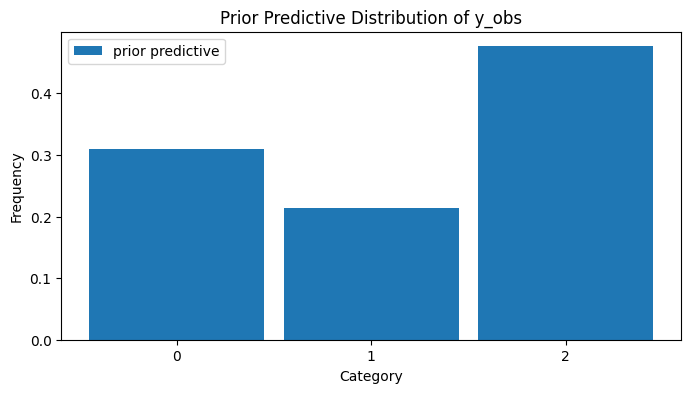

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y_obs]


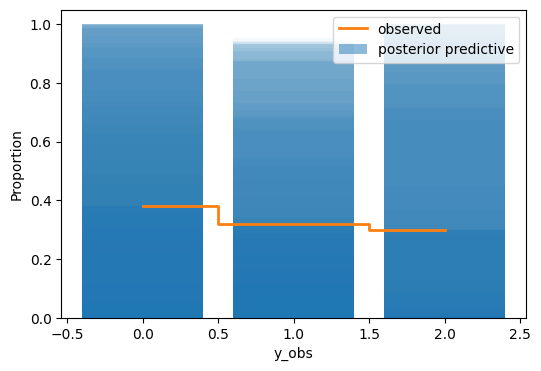

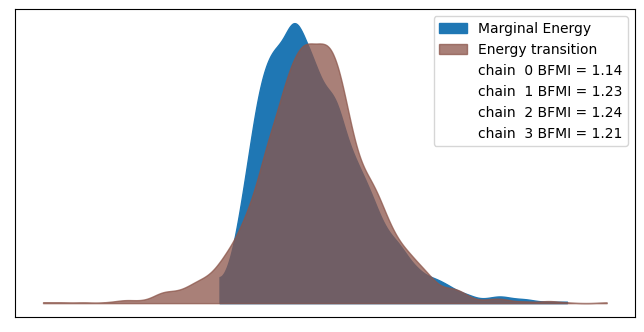

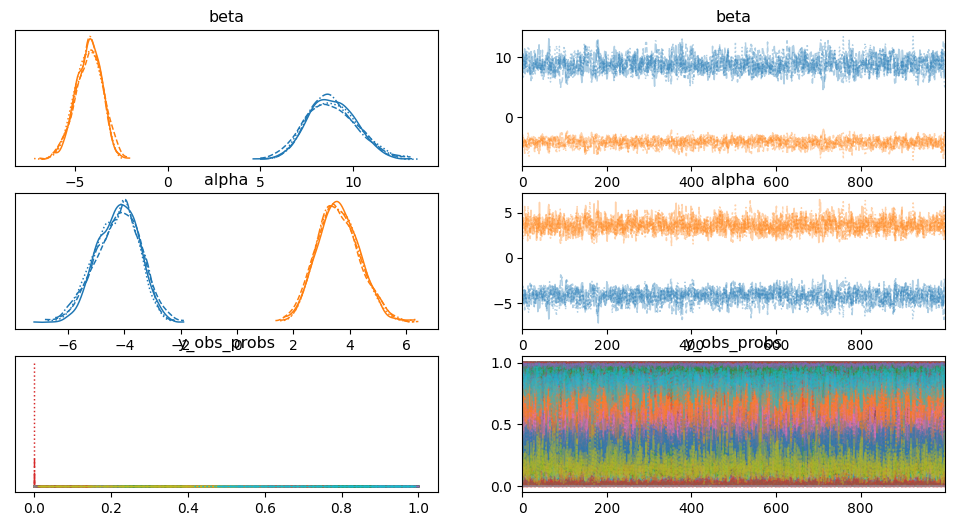

/Users/adithyan/Documents/MScProject/bayes_ordinal/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


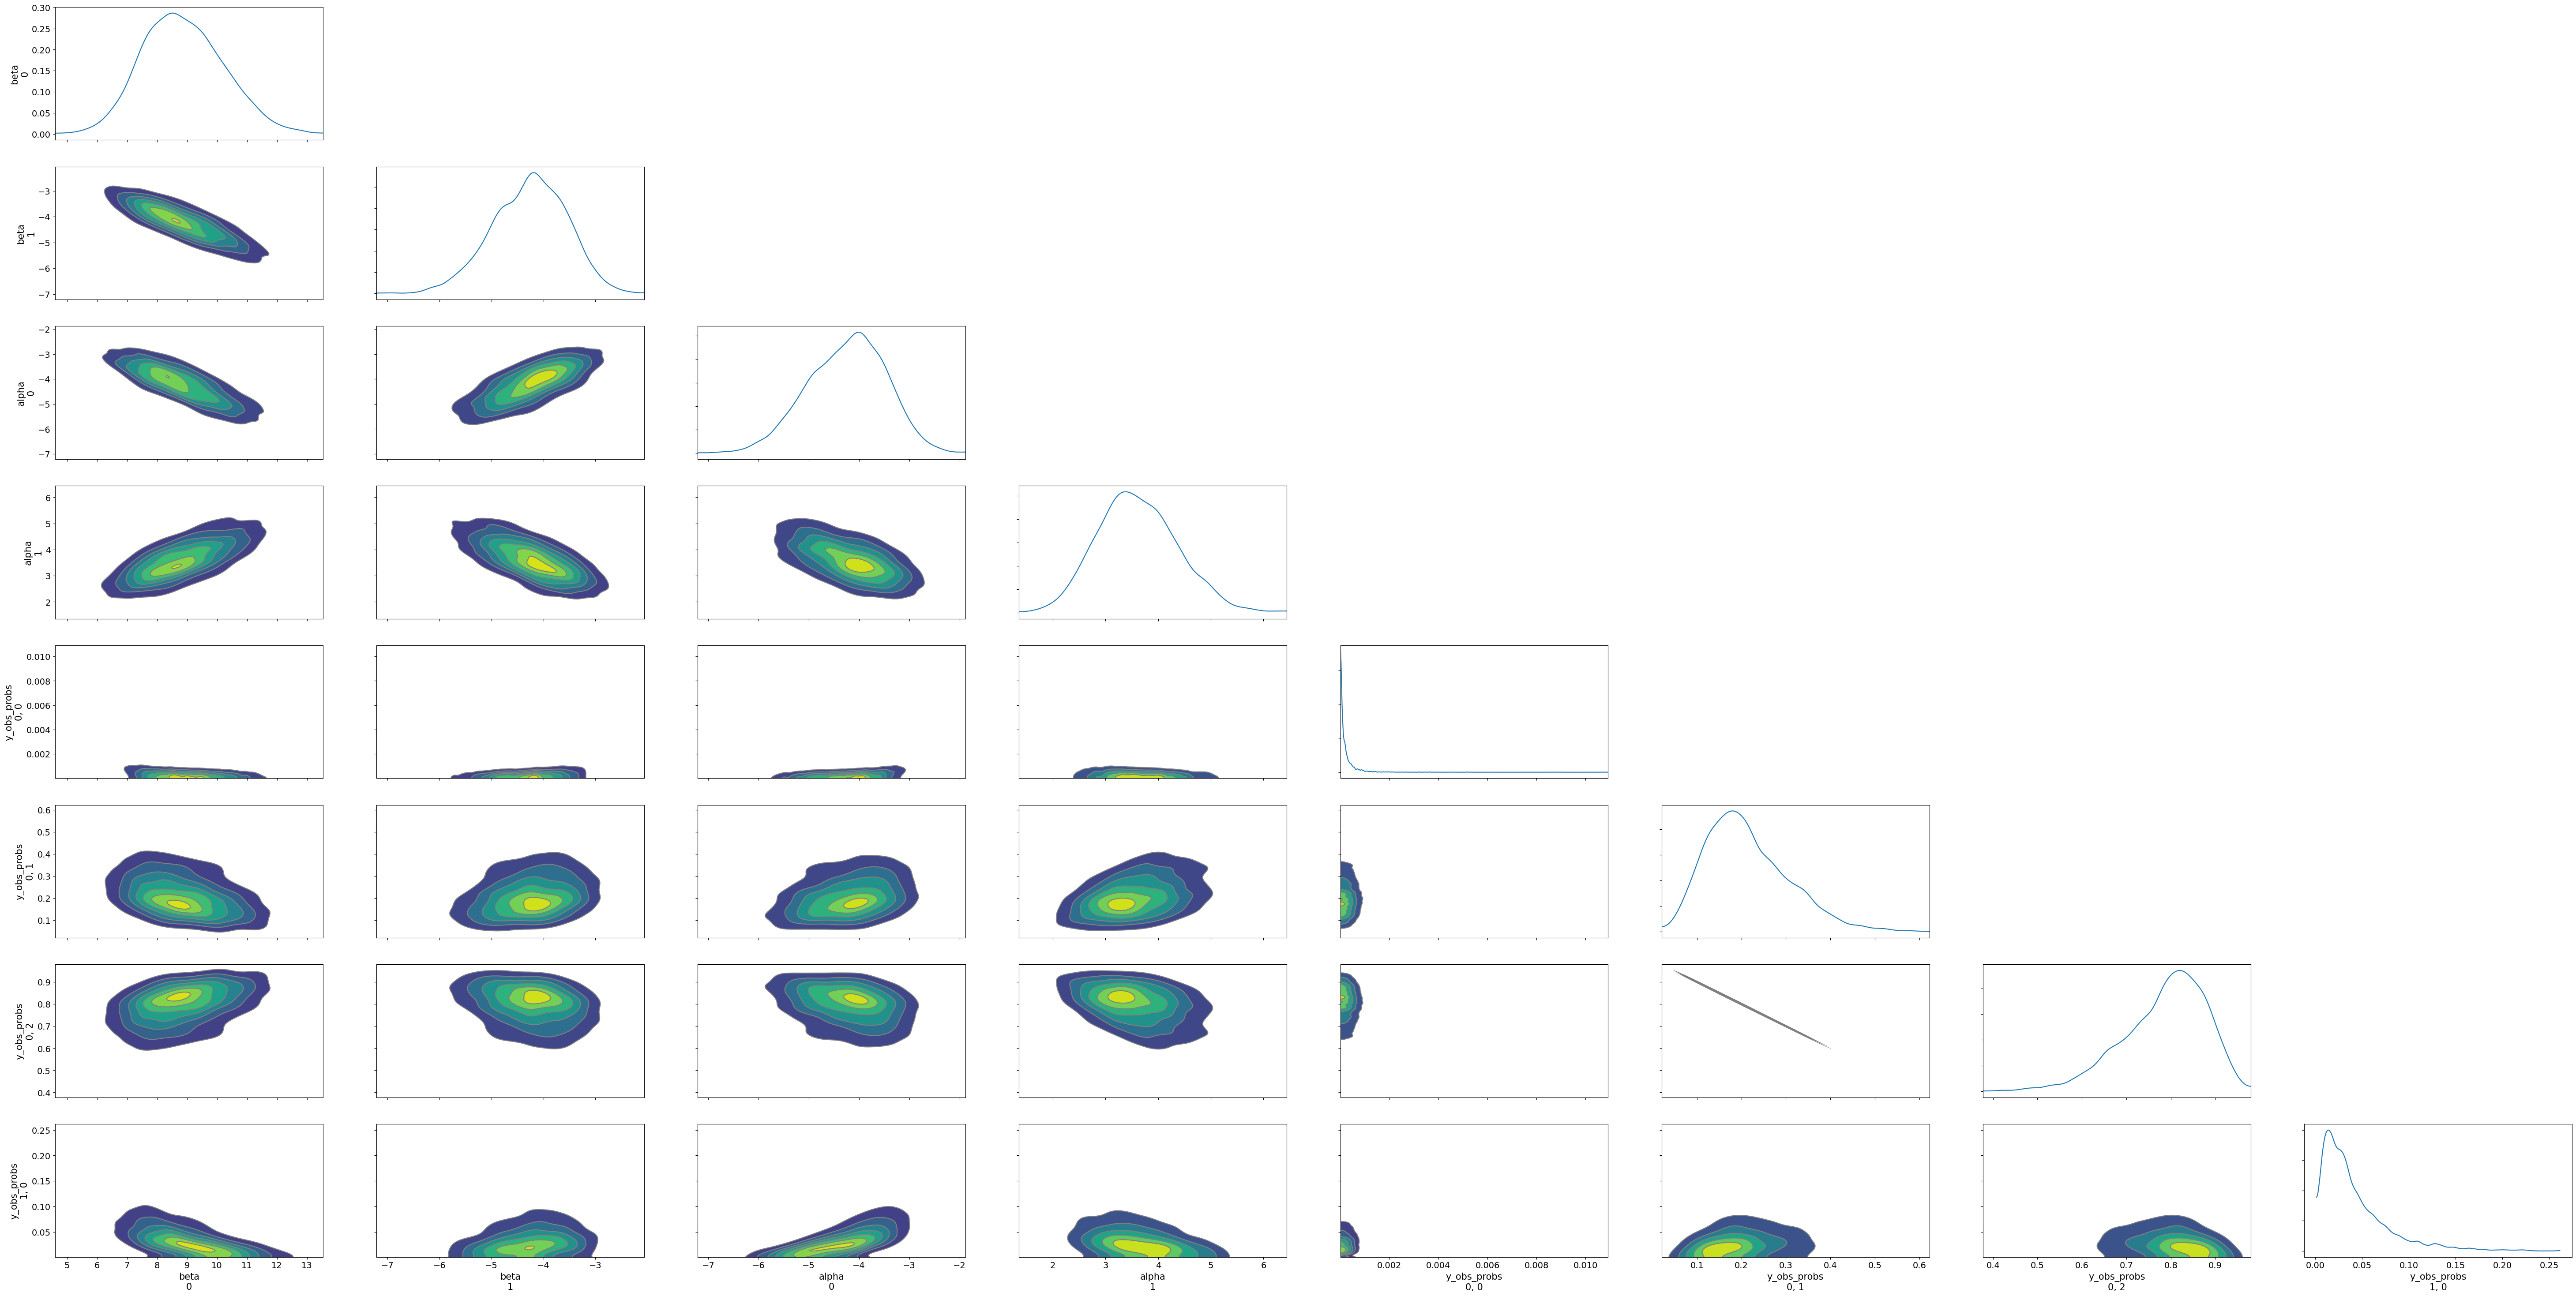

ppc keys: ['posterior_predictive', 'observed_data']


In [25]:
# Cell 3: Build & run most of the workflow (no CV yet)
cfg = {
    "draws": 1000, "tune": 1000, "chains": 4,
    "run_prior": True, "run_ppc": True,
    "run_diagnostics": True, "run_cv": False,
    "progressbar": True
}

results = run_workflow(
    model_fn={"cum": cumulative_model},
    y=y, X=X, K=K, config=cfg
)
print("ppc keys:", list(results["ppc"].keys()))
# prior_idata = results["prior_idata"]["cum"]
# idata       = results["idata"]["cum"]
# ppc       = results["ppc"]["model"]
# diag        = results["diagnostics"]["cum"]
